#  Singlet doublet fermion dark matter model

We expect here degenerate masses so we must be carefull about the DM particles that is registered by micrOMEGAS:

We need to edit prtcls1.mld to have the righ order with Nv0 appearing first

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import os, sys, inspect
import commands
from hep import *

## Feynrules implementation
[Preliminary Analysis](../../../2016/micromegas_feynrules/correr_micrOMEGAs-markov.ipynb)

See also full results with user galcen in fisica? or gfif?

In [3]:
#1. CHOOSE A BENCHMARK POINT  
#if 1==1:
#    MDF = 110.;MN = 101.;tanb = 10.0;lam = 0.15;v=246.2196; 
def run_feynrules_SDFDM(MDF = 110.,MN = 101.,lu = 0.1,ld = 0.1,v=246.2196,path='../micromegas/SDFDM/main'):
    o={}
    #2. File to run micrOMEGAS installed in galcen
    
    #lu=lam*np.sin(np.arctan(tanb))
    #ld=lam*np.cos(np.arctan(tanb))
    
    M=np.matrix([[ MN,                -ld*v/np.sqrt(2.),  lu*v/np.sqrt(2.)],
             [ -ld*v/np.sqrt(2.),  0.,                MDF ],
             [ lu*v/np.sqrt(2.),  MDF,               0. ]])

    (Mchi,N)=np.linalg.eig(M)
    
    pd.Series({'MDF':MDF,'MN':MN,'ld':ld,'lu':lu,\
               'N11':N[0,0],'N12':N[0,1],'N13':N[0,2],\
               'N21':N[1,0],'N22':N[1,1],'N23':N[1,2],\
               'N31':N[2,0],'N32':N[2,1],'N33':N[2,2]}).to_csv('mo.dat',sep='\t')

    #3. Run micromegas
    mo=commands.getoutput('%s mo.dat' %path)

    #4. Extrac some of the output (Dependence of the micrOMEGAs vertion)
    o['Full']=mo
    o['Mchi']=Mchi
    o['N']=N
    o['Omega']=eval(mo.split('Omega=')[1].split('\n')[0])
    o['proton_SI']=eval(mo.split('proton  SI')[1].split('[')[0])
    o['proton_SD']=eval(mo.split('proton  SI')[1].split('SD')[1].split('[')[0])
    #o['neutron_SI']=eval(mo.split('proton  SI')[1].split('[')[0])
    #o['neutron_SD']=eval(mo.split('proton  SI')[1].split('SD')[1].split('[')[0])
    o['sigmav']=eval(mo.split('annihilation cross section')[1].split('cm^3/s\n')[0])
    return o


## Check one point

In [18]:
a=hep(MODEL='SimplifiedDMSDFDM')

`a-object` is an object with many attributes and methods. Use the tab to explore them. Some of them are
* a.Series: [pandas](http://pandas.pydata.org/) Series object with the "relevant" variables 
* a.LHA: Input LesHouces file as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runSPheno() -> a.LHA_out: return LHA output files as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runmicromegas() -> a.runSPheno() -> Updated the `a-object`  with micrOMEGAS "relevant" output

In [19]:
v=a.vev
#lambda_1=0.13
mdf=1100
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][2]='%0.8E       #MDF' %mdf
moc=a.runmicromegas(Direct_Detection=True)
print 'Omega h^2, SI proton, neutron =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI

Omega h^2, SI proton, neutron = 0.115 8.977e-12 9.253e-12


In [20]:
a.Series

GFFermiconstant    1.166370e-05
MDF                1.100000e+03
MnINPUT            2.000000e+03
Zbosonpolemass     9.118870e+01
alphasMZSMMSbar    1.187000e-01
lambda1INPUT       1.300000e-01
lamdINPUT          1.000000e-01
lamuINPUT          1.000000e-01
mbmbSMMSbar        4.180000e+00
mtaupole           1.776690e+00
mtoppole           1.735000e+02
Omega_h2           1.150000e-01
proton_SI          8.977000e-12
neutron_SI         9.253000e-12
dtype: float64

In [21]:

#mo=run_feynrules_SDFDM(MDF = eval(a.LHA.blocks['MINPAR'][2]),MN = eval(a.LHA.blocks['MINPAR'][3]),\
#                        lu = eval(a.LHA.blocks['MINPAR'][4]),ld = eval(a.LHA.blocks['MINPAR'][5]),v=a.vev)

mo=run_feynrules_SDFDM(MDF = -a.Series.MDF,MN = a.Series.MnINPUT,\
                        lu = a.Series.lamuINPUT,ld = a.Series.lamdINPUT ,v=a.vev)
#implement sigma_v
mo=a.micromegas_output(mo['Full'])
print mo.Omega_h2,mo.proton.SI

0.12 1.733e-11


## Scan $m_{DM}$
### Higgsilino-like

In [23]:
df=pd.DataFrame()
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
dm_masses=np.linspace(100,1200,100)
for MDM in dm_masses:
    if np.where(dm_masses==MDM)[0][0]%10==0: #find the index of the array entry
        print np.where(dm_masses==MDM)[0][0]
    a.LHA.blocks['MINPAR'][2]='%0.8E       #MDF' %MDM  # -> Fill a.Series.MDF
    a.runmicromegas(Direct_Detection=True)
    mo=run_feynrules_SDFDM(MDF = -a.Series.MDF,MN = a.Series.MnINPUT,\
                        lu = a.Series.lamuINPUT,ld = a.Series.lamdINPUT ,v=a.vev)
    mo=a.micromegas_output(mo['Full'])
    a.Series['Omega_h2_official']=mo.Omega_h2
    a.Series['proton_SI_official']=mo.proton.SI
    a.Series['neutron_SI_official']=mo.neutron.SI
    df=df.append(a.Series,ignore_index=True)

0
10
20
30
40
50
60
70
80
90


### Relic density

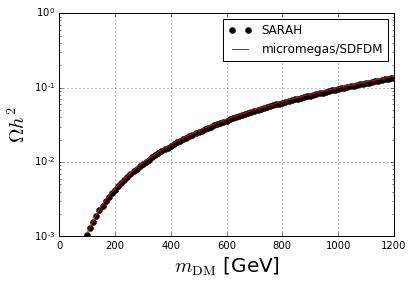

In [26]:
plt.semilogy(df.MDF,df.Omega_h2,'ko',label='SARAH')
plt.semilogy(df.MDF,df.Omega_h2_official,'r-',label='micromegas/SDFDM')
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.ylabel(r'$\Omega h^2$',size=20)
plt.grid()
plt.legend(loc='best')
plt.savefig('omega.pdf')


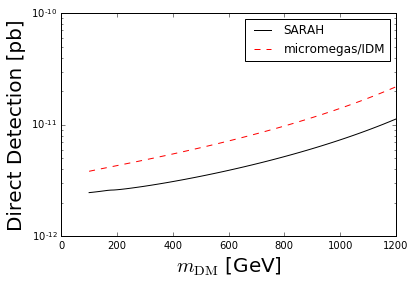

In [28]:
plt.semilogy(df.MDF,df.proton_SI,'k-',label='SARAH')
plt.semilogy(df.MDF,df.proton_SI_official,'r--',label='micromegas/IDM')
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.ylabel(r'Direct Detection [pb]' ,size=20)
plt.legend(loc='best')
plt.savefig('dd.pdf')

### Singlet-like

In [29]:
dn=pd.DataFrame()
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][2]='%0.8E       #MDF' %1200  # -> Fill a.Series.MDF

dm_masses=np.linspace(100,1200,100)
for MDM in dm_masses:
    if np.where(dm_masses==MDM)[0][0]%10==0: #find the index of the array entry
        print np.where(dm_masses==MDM)[0][0]
    a.LHA.blocks['MINPAR'][3]='%0.8E       #MN' %MDM  # -> Fill a.Series.MN
    a.runmicromegas(Direct_Detection=True)
    mo=run_feynrules_SDFDM(MDF = -a.Series.MDF,MN = a.Series.MN,\
                        lu = a.Series.lamuINPUT,ld = a.Series.lamdINPUT ,v=a.vev)
    mo=a.micromegas_output(mo['Full'])
    a.Series['Omega_h2_official']=mo.Omega_h2
    a.Series['proton_SI_official']=mo.proton.SI
    a.Series['neutron_SI_official']=mo.neutron.SI
    dn=dn.append(a.Series,ignore_index=True)

0
10
20
30
40
50
60
70
80
90


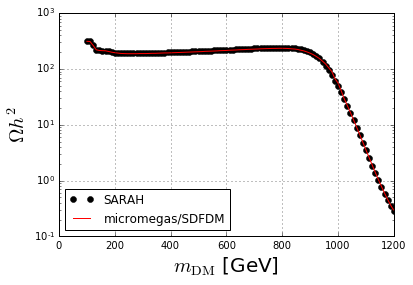

In [31]:
plt.semilogy(dn.MN,dn.Omega_h2,'ko',label='SARAH')
plt.semilogy(dn.MN,dn.Omega_h2_official,'r-',label='micromegas/SDFDM')
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.ylabel(r'$\Omega h^2$',size=20)
plt.grid()
plt.legend(loc='best')
plt.savefig('omega.pdf')

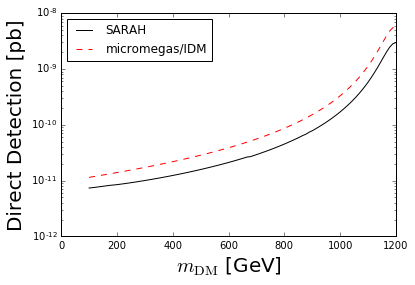

In [32]:
plt.semilogy(dn.MN,dn.proton_SI,'k-',label='SARAH')
plt.semilogy(dn.MN,dn.proton_SI_official,'r--',label='micromegas/IDM')
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.ylabel(r'Direct Detection [pb]' ,size=20)
plt.legend(loc='best')
plt.savefig('dd.pdf')

## Pure higssino limit

In [43]:
v=a.vev
#lambda_1=0.13
mdf=100
mn=2000
lambdau=1E-4
lambdad=1E-4
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][2]='%0.8E       #MDF' %mdf
a.LHA.blocks['MINPAR'][3]='%0.8E       #MN' %mn
a.LHA.blocks['MINPAR'][4]='%0.8E       # lamuINPUT' %lambdau
a.LHA.blocks['MINPAR'][5]='%0.8E       # lamdINPUT' %lambdad
moc=a.runmicromegas(Direct_Detection=True)
print 'Omega h^2, SI proton, neutron =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI

Omega h^2, SI proton, neutron = 0.00103 2.47e-24 2.536e-24


In [40]:
a.LHA.blocks['MINPAR'].entries

_dict([(1, '1.3000000E-01  # lambda1INPUT'),
       (2, '1.10000000E+03       #MDF'),
       (3, '2.00000000E+03       #MN'),
       (4, '0.00000000E+00       # lamuINPUT'),
       (5, '0.00000000E+00       # lamdINPUT')])

In [45]:
mo=run_feynrules_SDFDM(MDF = -a.Series.MDF,MN = a.Series.MN,\
                        lu = a.Series.lamuINPUT,ld = a.Series.lamdINPUT ,v=a.vev)
#implement sigma_v
mo=a.micromegas_output(mo['Full'])
print mo.Omega_h2,mo.proton.SI

0.00107 3.835e-24


[Jupyter home](./draft.pdf)